In [1]:
from datetime import datetime, timedelta
from dateutil import parser

def normalize_date_str(date_str: str) -> str:
    """Convert human-readable dates to YYYY-MM-DD."""
    if not date_str:
        return None
    return parser.parse(date_str).strftime("%Y-%m-%d")

In [2]:
from langgraph.graph import StateGraph, START, END

In [3]:
from dataclasses import dataclass
from typing import List, Dict, Any, Optional
from pydantic import BaseModel

class TravelRequest(BaseModel):
    """Raw travel intent extracted from user input"""

    origin: Optional[str] = None
    destination: Optional[str] = None
    departure_date: Optional[str] = None
    return_date: Optional[str] = None
    travelers: Optional[int] = None
    budget: Optional[float] = None
    preferences: Optional[List[str]] = None
    trip_type: Optional[str] = None


@dataclass
class FlightOption:
    """Flight search result"""
    airline: str
    departure_time: str
    arrival_time: str
    duration: str
    price: float
    stops: int

@dataclass
class HotelOption:
    """Hotel search result"""
    name: str
    rating: float
    price_per_night: float
    amenities: List[str]
    location: str
    distance_to_center: float

@dataclass
class WeatherInfo:
    """Weather information"""
    temperature_range: str
    conditions: str
    precipitation_chance: int
    recommendations: List[str]

@dataclass
class Attraction:
    """Tourist attraction information"""
    name: str
    category: str
    rating: float
    estimated_time: str
    cost: float
    description: str

@dataclass
class DayPlan:
    """Daily itinerary"""
    day: int
    date: str
    activities: List[Dict[str, Any]]
    estimated_cost: float
    notes: str

print("📋 Data structures defined:")
print("✅ TravelRequest - User input structure")
print("✅ FlightOption - Flight search results")
print("✅ HotelOption - Hotel search results")
print("✅ WeatherInfo - Weather data")
print("✅ Attraction - Points of interest")
print("✅ DayPlan - Daily itinerary structure")


📋 Data structures defined:
✅ TravelRequest - User input structure
✅ FlightOption - Flight search results
✅ HotelOption - Hotel search results
✅ WeatherInfo - Weather data
✅ Attraction - Points of interest
✅ DayPlan - Daily itinerary structure


In [4]:
# TravelPlannerState is a typed dictionary acting as a shared memory/state object.

# It accumulates everything the planner needs: inputs, search results, selections, itinerary, costs, errors, and final plan.

# create_initial_state() bootstraps an empty state before the agent begins planning.

In [5]:
from typing import TypedDict

class TravelPlannerState(TypedDict): #TravelPlannerState is essentially the master state object that holds everything about the travel planning workflow.
    """
    Complete state for the travel planner agent.

    This state flows through all nodes and accumulates information
    throughout the planning process.
    """
    # User input and preferences
    user_request: str                    # Original user input the raw string the user typed (e.g., "Plan me a trip to Rome in November").
    travel_request: Optional[TravelRequest]  # Parsed travel details a structured version of that, parsed into your TravelRequest dataclass.
    trip_days: int
    trip_nights: int
    # Search results
    #List[HotelOption] is a type hint in Python that means "a list of HotelOption objects."
    flight_options: List[FlightOption]   # Available flights flight_options: list of FlightOption results from a flight API.
    hotel_options: List[HotelOption]     # Available hotels hotel_options: list of HotelOption results from a hotel API.
    weather_info: Optional[WeatherInfo]  # Destination weather weather_info: one WeatherInfo object for destination forecast.
    attractions: List[Attraction]        # Local attractions attractions: list of Attraction objects (tourist spots).

    # Selected options
    selected_flight: Optional[FlightOption]  # Chosen flight selected_flight: the chosen FlightOption.
    selected_hotel: Optional[HotelOption]    # Chosen hotel selected_hotel: the chosen HotelOption.

    # Planning results
    itinerary: List[DayPlan]            # Day-by-day plan
    total_cost: float                   # Total trip cost
    cost_breakdown: Dict[str, float]    # Detailed costs

    # Process control
    planning_stage: str                 # Current planning phase
    errors: List[str]                   # Any errors encountered
    completed_steps: List[str]          # Completed planning steps

    # Final output
    final_plan: str                     # Formatted travel plan

# Initialize our state with default values
def create_initial_state(user_request: str) -> TravelPlannerState:
    """Create initial state from user request"""
    return TravelPlannerState(
        user_request=user_request,
        travel_request=None,
        flight_options=[],
        hotel_options=[],
        weather_info=None,
        attractions=[],
        selected_flight=None,
        selected_hotel=None,
        itinerary=[],
        total_cost=0.0,
        cost_breakdown={},
        planning_stage="input_processing",
        errors=[],
        completed_steps=[],
        final_plan=""
    )

print("🏗️ Travel Planner State defined!")
print("📊 State includes:")
print("   • User requests and preferences")
print("   • Search results for flights, hotels, attractions")
print("   • Selected options and planning results")
print("   • Process control and error handling")
print("   • Final formatted plan")
print("\n💡 This state will flow through all planning nodes")


🏗️ Travel Planner State defined!
📊 State includes:
   • User requests and preferences
   • Search results for flights, hotels, attractions
   • Selected options and planning results
   • Process control and error handling
   • Final formatted plan

💡 This state will flow through all planning nodes


In [6]:
# This code is part of your travel planner agent pipeline.
# It handles the first stage:

# Takes the raw user request string (like "Plan me a family vacation to Rome next July for 4 people with a $5000 budget").

# Tries to extract structured travel details from it:

# Origin, destination, dates, travelers, budget, preferences, trip type.

# Stores the results in your TravelPlannerState object for downstream steps (flight search, hotel booking, itinerary planning, etc).

# It has two extraction strategies:

# Use an LLM (ChatGPT via ChatOpenAI) if available.

# Otherwise, fallback to regex parsing.

In [7]:
from langchain_ollama import ChatOllama
from langchain_core.messages import SystemMessage, HumanMessage
import re


system_msg = SystemMessage(
    content="""
        You are a strict information extraction system.
        If a value is missing, return null.
        Do not invent dates, budgets, or locations.
        """
    )
# Initialize the LLM for parsing user input
def get_llm():
    """Get local LLM via Ollama"""
    return ChatOllama(
        model="llama3",
        base_url="http://localhost:11434",
        temperature=0
    )
    
from pydantic import BaseModel
from typing import Optional, List

class TravelRequest(BaseModel):
    origin: Optional[str]
    destination: Optional[str]
    departure_date: Optional[str]
    return_date: Optional[str]
    travelers: Optional[int]
    budget: Optional[float]
    preferences: Optional[List[str]]
    trip_type: Optional[str]

llm = get_llm()

structured_llm = llm.with_structured_output(TravelRequest)


def extract_with_regex(text: str) -> dict:
    """Fallback regex-based extraction for when LLM is not available"""
    #used to extract travel details from user input using regex patterns
    extracted = {}

    # Look for month names with dates
    month_patterns = [
        r'(January|February|March|April|May|June|July|August|September|October|November|December)\s+(\d{1,2}),?\s+(\d{4})',
        r'(Jan|Feb|Mar|Apr|May|Jun|Jul|Aug|Sep|Oct|Nov|Dec)\s+(\d{1,2}),?\s+(\d{4})'
    ]

    # Look for numeric dates
    numeric_patterns = [
        r'(\d{4}-\d{2}-\d{2})',  # YYYY-MM-DD
        r'(\d{1,2}/\d{1,2}/\d{4})',  # MM/DD/YYYY or M/D/YYYY
        r'(\d{1,2}-\d{1,2}-\d{4})',  # MM-DD-YYYY
    ]

    dates = []

    # Try month name patterns first
    for pattern in month_patterns:
        matches = re.findall(pattern, text, re.IGNORECASE)
        for match in matches:
            try:
                month_name, day, year = match
                # Convert month name to number
                month_map = {
                    'january': '01', 'jan': '01', 'february': '02', 'feb': '02',
                    'march': '03', 'mar': '03', 'april': '04', 'apr': '04',
                    'may': '05', 'june': '06', 'jun': '06', 'july': '07', 'jul': '07',
                    'august': '08', 'aug': '08', 'september': '09', 'sep': '09',
                    'october': '10', 'oct': '10', 'november': '11', 'nov': '11',
                    'december': '12', 'dec': '12'
                }
                month_num = month_map.get(month_name.lower(), '01')
                date_str = f"{year}-{month_num}-{day.zfill(2)}"
                dates.append(date_str)
            except:
                continue

    # If no month name dates found, try numeric patterns
    if not dates:
        for pattern in numeric_patterns:
            dates.extend(re.findall(pattern, text))

    # Extract budget - look for dollar amounts
    budget_patterns = [
        r'\$(\d{1,3}(?:,\d{3})*)',  # $1,000 or $5000
        r'budget.*?(\d{1,3}(?:,\d{3})*)',  # budget of 1000
        r'(\d{1,3}(?:,\d{3})*)\s*dollars?',  # 1000 dollars
    ]

    budget = 2000.0  # default
    for pattern in budget_patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            budget = float(match.group(1).replace(',', ''))
            break
    extracted['budget'] = budget

    # Extract number of travelers
    traveler_patterns = [
        r'(\d+)\s+(?:people|person|traveler|passenger)',
        r'for\s+(\d+)',
        r'(\d+)\s+of\s+us'
    ]

    travelers = 1
    for pattern in traveler_patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            travelers = int(match.group(1))
            break
    extracted['travelers'] = travelers

    # Extract cities (simple approach - look for capitalized words)
    cities = re.findall(r'\b[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*\b', text)

    # Assume first city is origin, second is destination
    if len(cities) >= 2:
        extracted['origin'] = cities[0]
        extracted['destination'] = cities[1]
    elif len(cities) == 1:
        extracted['destination'] = cities[0]
        extracted['origin'] = "New York"  # Default
    else:
        extracted['origin'] = "New York"
        extracted['destination'] = "Paris"

    # Set dates
    if len(dates) >= 2:
        extracted['departure_date'] = dates[0]
        extracted['return_date'] = dates[1]
    else:
        # Default dates
        today = datetime.now()
        extracted['departure_date'] = (today + timedelta(days=30)).strftime("%Y-%m-%d")
        extracted['return_date'] = (today + timedelta(days=37)).strftime("%Y-%m-%d")

    # Trip type detection
    business_keywords = ['business', 'work', 'conference', 'meeting']
    leisure_keywords = ['vacation', 'holiday', 'leisure', 'fun', 'relax']
    family_keywords = ['family', 'kids', 'children']
    adventure_keywords = ['adventure', 'hiking', 'skiing', 'diving']

    text_lower = text.lower()
    if any(word in text_lower for word in business_keywords):
        extracted['trip_type'] = 'business'
    elif any(word in text_lower for word in family_keywords):
        extracted['trip_type'] = 'family'
    elif any(word in text_lower for word in adventure_keywords):
        extracted['trip_type'] = 'adventure'
    else:
        extracted['trip_type'] = 'leisure'

    # Extract preferences
    preference_keywords = {
        'museums': ['museum', 'art', 'gallery', 'culture'],
        'local cuisine': ['food', 'restaurant', 'cuisine', 'dining', 'eat'],
        'history': ['history', 'historical', 'ancient', 'heritage'],
        'nature': ['nature', 'park', 'hiking', 'outdoor'],
        'nightlife': ['nightlife', 'bar', 'club', 'party'],
        'shopping': ['shopping', 'shop', 'market', 'boutique'],
        'architecture': ['architecture', 'building', 'cathedral', 'church']
    }

    preferences = []
    for pref, keywords in preference_keywords.items():
        if any(keyword in text_lower for keyword in keywords):
            preferences.append(pref)

    if not preferences:
        preferences = ['local cuisine', 'history', 'museums']  # Default

    extracted['preferences'] = preferences

    return extracted

def process_user_input(state: TravelPlannerState) -> TravelPlannerState:
    """
    Parse user input and extract travel requirements using a local LLM
    with structured output. Falls back to sample data if needed.
    """
    print("🔍 Processing user input...")
    user_request = state["user_request"]

    try:
        llm = get_llm()
        structured_llm = llm.with_structured_output(TravelRequest)

        print("🤖 Using LLM for intelligent extraction...")

        system_prompt = """You are a strict information extraction system.

Rules:
- Extract only information explicitly stated or strongly implied.
- If a value is missing, return null.
- Do NOT invent dates, budgets, or locations.
- Do NOT explain reasoning.
"""

        messages = [
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_request)
        ]

        # ✅ Invoke ONCE and get a TravelRequest object
        extracted: TravelRequest = structured_llm.invoke(messages)

        # ✅ Normalize dates ONCE
        extracted.departure_date = normalize_date_str(extracted.departure_date)
        extracted.return_date = normalize_date_str(extracted.return_date)

        print("✅ Parsed request:")
        print(f"   🏙️ Origin: {extracted.origin}")
        print(f"   🎯 Destination: {extracted.destination}")
        print(f"   📅 Dates: {extracted.departure_date} to {extracted.return_date}")
        print(f"   👥 Travelers: {extracted.travelers}")
        print(f"   💰 Budget: {extracted.budget}")
        print(f"   🎭 Type: {extracted.trip_type}")
        print(f"   🎨 Preferences: {extracted.preferences}")

        updated_state = dict(state)
        updated_state.update({
            "travel_request": extracted,
            "planning_stage": "flight_search",
            "completed_steps": state["completed_steps"] + ["input_processing"]
        })

        return TravelPlannerState(**updated_state)

    except Exception as e:
        print(f"❌ Error processing input: {e}")
        print("🔄 Falling back to sample data...")

        fallback_request = TravelRequest(
            origin="New York",
            destination="Paris",
            departure_date=normalize_date_str("June 15, 2024"),
            return_date=normalize_date_str("June 22, 2024"),
            travelers=2,
            budget=3000.0,
            preferences=["museums", "local cuisine", "history"],
            trip_type="leisure"
        )

        updated_state = dict(state)
        updated_state.update({
            "travel_request": fallback_request,
            "planning_stage": "flight_search",
            "completed_steps": state["completed_steps"] + ["input_processing"],
            "errors": state["errors"] + [f"Input processing fallback used: {str(e)}"]
        })

        return TravelPlannerState(**updated_state)



In [8]:
def compute_trip_duration(state: TravelPlannerState) -> TravelPlannerState:
    from datetime import datetime

    req = state["travel_request"]

    if not req or not req.departure_date or not req.return_date:
        raise ValueError("Missing dates – cannot compute trip duration")

    departure = datetime.fromisoformat(req.departure_date)
    return_date = datetime.fromisoformat(req.return_date)

    days = (return_date - departure).days
    nights = max(days - 1, days)

    if days <= 0:
        raise ValueError("Invalid trip dates")

    state["trip_days"] = days
    state["trip_nights"] = nights

    print(f"🧮 Trip duration computed: {days} days, {nights} nights")

    return state

In [9]:
# Test the enhanced process_user_input function

print("🧪 Testing the enhanced travel request extraction:")
print("=" * 60)

# Test with a simple example first
test_input = "I want to travel from London to Paris from June 15, 2024 to June 25, 2024. I have a budget of $4000 for 2 people. I'm interested in temples, food, and gardens."

print(f"\n🔍 Test: {test_input}")
print("-" * 50)

# Create initial state , getting the initial variable data
test_state = create_initial_state(test_input)

# Process the input
state = process_user_input(test_state)

# Date sanity check – must be ISO before planning
req = state["travel_request"]

assert req.departure_date is None or req.departure_date.count("-") == 2, req.departure_date
assert req.return_date is None or req.return_date.count("-") == 2, req.return_date

print("Dates are normalized and safe for planning")


if state['travel_request']:
    tr = state['travel_request']
    print(f"✅ Successfully extracted:")
    print(f"   🏙️ Route: {tr.origin} → {tr.destination}")
    print(f"   📅 Dates: {tr.departure_date} to {tr.return_date}")
    print(f"   👥 Travelers: {tr.travelers}")
    print(f"   💰 Budget: ${tr.budget}")
    print(f"   🎭 Type: {tr.trip_type}")
    print(f"   🎨 Preferences: {', '.join(tr.preferences)}")
else:
    print("❌ Failed to extract travel request")

print("\n" + "=" * 60)
print("🎯 The function now intelligently extracts travel information from natural language!")
print("💡 It uses LLM when available, with regex fallback for reliability.")


🧪 Testing the enhanced travel request extraction:

🔍 Test: I want to travel from London to Paris from June 15, 2024 to June 25, 2024. I have a budget of $4000 for 2 people. I'm interested in temples, food, and gardens.
--------------------------------------------------
🔍 Processing user input...
🤖 Using LLM for intelligent extraction...
✅ Parsed request:
   🏙️ Origin: London
   🎯 Destination: Paris
   📅 Dates: 2024-06-15 to 2024-06-25
   👥 Travelers: 2
   💰 Budget: 4000.0
   🎭 Type: round-trip
   🎨 Preferences: ['temples', 'food', 'gardens']
Dates are normalized and safe for planning
✅ Successfully extracted:
   🏙️ Route: London → Paris
   📅 Dates: 2024-06-15 to 2024-06-25
   👥 Travelers: 2
   💰 Budget: $4000.0
   🎭 Type: round-trip
   🎨 Preferences: temples, food, gardens

🎯 The function now intelligently extracts travel information from natural language!
💡 It uses LLM when available, with regex fallback for reliability.


In [9]:
# It’s a demo cell showing how to work with the TravelPlannerState object in practice.

# It walks through 4 main operations:

# Create Initial State → use create_initial_state(user_input) to build the starting state with default values and the raw user request.

# Process Through Nodes → run the state through a function like process_user_input to parse structured details (origin, destination, dates, budget) and update the planning stage.

# Access State Properties → iterate over all keys in the state to inspect what data it contains (lists, dicts, None, or values).

# Update State → make a copy of the state, change some fields (planning_stage, total_cost, etc.), and reconstruct a new validated TravelPlannerState.

# In short: The code is a tutorial/example that shows how to initialize, process, inspect, and update the travel planner’s state as it flows through the planning pipeline.

In [10]:
# This function (search_flights) is Node 2 in your travel planner pipeline.
# Its job is to:

# Look at the structured TravelRequest inside the state.

# "Search" for flights (mock data here, API in real-world).

# Filter results by budget.

# Update the state with valid flight options and move the process forward.

In [10]:
# Node 2: Flight Search - Find available flights



def search_flights(state: TravelPlannerState) -> TravelPlannerState:
    """
    Search for available flights based on travel request.

    This node:
    1. Uses travel request details to search flights
    2. Filters results based on budget and preferences
    3. Returns top flight options
    """
    print("✈️ Searching for flights...")

    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for flight search"]
        )

    travel_req = state['travel_request']

    # Mock flight search (in production, integrate with flight APIs)
    mock_flights = [
        FlightOption(
            airline="Air France",
            departure_time="08:00",
            arrival_time="21:30",
            duration="7h 30m",
            price=650.0,
            stops=0
        ),
        FlightOption(
            airline="Delta",
            departure_time="14:15",
            arrival_time="04:45+1",
            duration="8h 30m",
            price=580.0,
            stops=1
        ),
        FlightOption(
            airline="British Airways",
            departure_time="22:00",
            arrival_time="11:15+1",
            duration="7h 15m",
            price=720.0,
            stops=0
        )
    ]

    # Filter by budget (flight costs for round trip)
    budget_per_person = travel_req.budget / travel_req.travelers / 2  # Rough estimate
    suitable_flights = [f for f in mock_flights if f.price <= budget_per_person]
    
    print(f"✅ Found {len(suitable_flights)} flights within budget:")
    for flight in suitable_flights:
        print(f"   • {flight.airline}: ${flight.price} ({flight.duration}, {flight.stops} stops)")

    # Create updated state
    updated_state = dict(state)
    updated_state.update({
        'flight_options': suitable_flights,
        'planning_stage': "hotel_search",
        'completed_steps': state['completed_steps'] + ["flight_search"]
    })
    return TravelPlannerState(**updated_state)

print("🛠️ Input processing and flight search nodes defined!")
print("✅ process_user_input - Parses user requests")
print("✅ search_flights - Finds available flights")

🛠️ Input processing and flight search nodes defined!
✅ process_user_input - Parses user requests
✅ search_flights - Finds available flights


In [11]:
# The function search_hotels finds hotel options for the trip, based on:

# Destination

# Trip duration

# Budget constraints

# It updates the state with hotels and moves the workflow to the weather check stage.

In [12]:
def search_hotels(state: TravelPlannerState) -> TravelPlannerState:
    """
    Search for hotels based on destination and preferences.
    """
    print("🏨 Searching for hotels...")
    print("HOTEL NODE STATE KEYS:", state.keys())
    print("trip_nights value:", state.get("trip_nights"))

    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for hotel search"]
        )

    travel_req = state['travel_request']

    # Mock hotel search (in production, integrate with hotel booking APIs)
    mock_hotels = [
        HotelOption(
            name="Hotel du Louvre",
            rating=4.5,
            price_per_night=180.0,
            amenities=["WiFi", "Breakfast", "Gym", "Concierge"],
            location="1st Arrondissement",
            distance_to_center=0.5
        ),
        HotelOption(
            name="Boutique Hotel Marais",
            rating=4.2,
            price_per_night=120.0,
            amenities=["WiFi", "Breakfast", "Bar"],
            location="4th Arrondissement",
            distance_to_center=1.2
        ),
        HotelOption(
            name="Budget Inn Montmartre",
            rating=3.8,
            price_per_night=85.0,
            amenities=["WiFi", "24h Reception"],
            location="18th Arrondissement",
            distance_to_center=3.5
        )
    ]
    
    nights = state["trip_nights"]

    # Filter hotels by budget
    remaining_budget = travel_req.budget - (len(state['flight_options']) * state['flight_options'][0].price * 2 if state['flight_options'] else 0)
    budget_per_night = (remaining_budget * 0.6) / nights  # Allocate 60% of remaining budget to hotels

    suitable_hotels = [h for h in mock_hotels if h.price_per_night <= budget_per_night]

    print(f"✅ Found {len(suitable_hotels)} hotels within budget (${budget_per_night:.0f}/night):")
    for hotel in suitable_hotels:
        total_cost = hotel.price_per_night * nights
        print(f"   • {hotel.name}: ${hotel.price_per_night}/night (${total_cost:.0f} total, ⭐{hotel.rating})")

    # Create updated state
    updated_state = dict(state)
    updated_state.update({
        'hotel_options': suitable_hotels,
        'planning_stage': "weather_check",
        'completed_steps': state['completed_steps'] + ["hotel_search"]
    })
    return TravelPlannerState(**updated_state)

In [13]:
import random

def check_weather(state: TravelPlannerState) -> TravelPlannerState:
    """
    Check weather conditions for the destination and dates.
    """
    print("🌤️ Checking weather conditions...")

    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for weather check"]
        )

    # Mock weather data (in production, integrate with weather APIs)
    weather_conditions = [
        ("Sunny", "20-25°C", 10, ["Light clothing", "Sunglasses", "Sunscreen"]),
        ("Partly Cloudy", "18-23°C", 20, ["Layers", "Light jacket", "Comfortable shoes"]),
        ("Rainy", "15-20°C", 70, ["Umbrella", "Waterproof jacket", "Boots"])
    ]

    # Randomly select weather for demo
    condition, temp_range, precip, recommendations = random.choice(weather_conditions)

    weather_info = WeatherInfo(
        temperature_range=temp_range,
        conditions=condition,
        precipitation_chance=precip,
        recommendations=recommendations
    )

    print(f"✅ Weather forecast:")
    print(f"   🌡️ Temperature: {weather_info.temperature_range}")
    print(f"   ☁️ Conditions: {weather_info.conditions}")
    print(f"   🌧️ Rain chance: {weather_info.precipitation_chance}%")
    print(f"   🎒 Pack: {', '.join(weather_info.recommendations)}")

    # Create updated state
    updated_state = dict(state)
    updated_state.update({
        'weather_info': weather_info,
        'planning_stage': "attractions_search",
        'completed_steps': state['completed_steps'] + ["weather_check"]
    })
    return TravelPlannerState(**updated_state)

print("🛠️ Hotel search and weather check nodes defined!")
print("✅ search_hotels - Finds suitable accommodations")
print("✅ check_weather - Gets destination weather info")


🛠️ Hotel search and weather check nodes defined!
✅ search_hotels - Finds suitable accommodations
✅ check_weather - Gets destination weather info


In [14]:
# Node 5: Find Attractions - Discover local points of interest

def find_attractions(state: TravelPlannerState) -> TravelPlannerState:
    """
    Find attractions and activities based on user preferences.
    """
    print("🎭 Finding attractions and activities...")

    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for attractions search"]
        )

    travel_req = state['travel_request']

    # Mock attractions database (in production, integrate with tourism APIs)
    all_attractions = [
        Attraction("Louvre Museum", "museum", 4.6, "3-4 hours", 17.0, "World's largest art museum"),
        Attraction("Eiffel Tower", "landmark", 4.5, "2-3 hours", 25.0, "Iconic iron tower with city views"),
        Attraction("Notre-Dame Cathedral", "historic", 4.4, "1-2 hours", 0.0, "Gothic masterpiece cathedral"),
        Attraction("Montmartre District", "neighborhood", 4.3, "4-5 hours", 0.0, "Artistic hill with Sacré-Cœur"),
        Attraction("Seine River Cruise", "activity", 4.2, "1-2 hours", 15.0, "Scenic boat tour of Paris"),
        Attraction("Local Cooking Class", "experience", 4.7, "3-4 hours", 85.0, "Learn French cuisine"),
        Attraction("Versailles Palace", "historic", 4.8, "6-8 hours", 20.0, "Opulent royal palace and gardens"),
        Attraction("Latin Quarter Food Tour", "food", 4.5, "3 hours", 65.0, "Taste local specialties")
    ]

    # Filter attractions based on preferences
    preferred_attractions = []
    for attraction in all_attractions:
        # Match user preferences
        if any(pref in attraction.category or pref in attraction.description.lower()
               for pref in travel_req.preferences):
            preferred_attractions.append(attraction)
        # Also include highly rated landmarks
        elif attraction.category in ["landmark", "historic"] and attraction.rating >= 4.4:
            preferred_attractions.append(attraction)

    # Sort by rating and limit to top options
    preferred_attractions.sort(key=lambda x: x.rating, reverse=True)
    top_attractions = preferred_attractions[:8]  # Limit to 8 attractions

    print(f"✅ Found {len(top_attractions)} attractions matching preferences:")
    for attraction in top_attractions:
        print(f"   • {attraction.name} (⭐{attraction.rating}): ${attraction.cost} - {attraction.estimated_time}")

    # Create updated state
    updated_state = dict(state)
    updated_state.update({
        'attractions': top_attractions,
        'planning_stage': "select_options",
        'completed_steps': state['completed_steps'] + ["attractions_search"]
    })
    return TravelPlannerState(**updated_state)


In [15]:
# select_best_options chooses the best flight and best hotel from the previously generated options.
# It uses a scoring system to balance cost, convenience, rating, and location.
# For each flight:

# Price: lower is better.

# Stops: each stop adds a $50 penalty (to reflect inconvenience).

# Chooses the flight with the lowest total score.

# Prints the selected flight.

# Example:

# Flight A: $600, 0 stops → score = 600

# Flight B: $580, 1 stop → score = 630
# Flight A wins, even though slightly more expensive, because it’s non-stop.

# The selection node:

# Scores flights (price + stop penalties).

# Scores hotels (price + rating penalty + location penalty).

# Chooses the lowest-score options.

# Updates the state with the best picks.

# Moves forward to itinerary creation.

In [16]:
# Node 6: Select Best Options - Choose flights and hotels

def select_best_options(state: TravelPlannerState) -> TravelPlannerState:
    """
    Select the best flight and hotel options based on criteria.
    """
    print("🎯 Selecting best options...")

    # Select best flight (balance price and convenience)
    best_flight = None
    if state['flight_options']:
        # Score flights (lower price + fewer stops = better score)
        scored_flights = []
        for flight in state['flight_options']:
            # Simple scoring: price weight + stops penalty
            score = flight.price + (flight.stops * 50)  # $50 penalty per stop
            scored_flights.append((score, flight))

        # Select flight with best score
        best_flight = min(scored_flights, key=lambda x: x[0])[1]
        print(f"✅ Selected flight: {best_flight.airline} (${best_flight.price}, {best_flight.stops} stops)")

    # Select best hotel (balance price, rating, and location)
    best_hotel = None
    if state['hotel_options']:
        # Score hotels (consider price, rating, and location)
        scored_hotels = []
        for hotel in state['hotel_options']:
            # Score: lower price is better, higher rating is better, closer to center is better
            price_score = hotel.price_per_night  # Lower is better
            rating_score = (5.0 - hotel.rating) * 20  # Convert rating to penalty (lower is better)
            location_score = hotel.distance_to_center * 10  # Distance penalty

            total_score = price_score + rating_score + location_score
            scored_hotels.append((total_score, hotel))

        # Select hotel with best score
        best_hotel = min(scored_hotels, key=lambda x: x[0])[1]
        print(f"✅ Selected hotel: {best_hotel.name} (${best_hotel.price_per_night}/night, ⭐{best_hotel.rating})")

    return TravelPlannerState(
        **state,
        selected_flight=best_flight,
        selected_hotel=best_hotel,
        planning_stage="create_itinerary",
        completed_steps=state['completed_steps'] + ["select_options"]
    )

print("🛠️ Attractions finder and selection nodes defined!")
print("✅ find_attractions - Discovers local points of interest")
print("✅ select_best_options - Chooses optimal flights and hotels")

🛠️ Attractions finder and selection nodes defined!
✅ find_attractions - Discovers local points of interest
✅ select_best_options - Chooses optimal flights and hotels


In [17]:
# create_itinerary builds a detailed day-by-day plan for the user’s trip, based on:

# Selected flight and hotel

# Attractions

# Trip duration

# Budget considerations (optional)

# It updates the state with the itinerary and moves the workflow to the next stage (calculate_budget).

# Purpose of updating state:

# Saves the generated itinerary in the planner state.

# Advances planning_stage → now the pipeline will proceed to budget calculation.

# Logs "create_itinerary" in completed_steps.

# Returns a new, updated state for the next node in the pipeline.
# This node:

# Uses trip dates and attractions to calculate daily plans.

# Adds key activities: arrival, attractions, meals, departure.

# Creates a structured itinerary with costs and notes.

# Updates the TravelPlannerState so the planner can continue to budgeting and final planning.

In [18]:
# Node 7: Create Itinerary - Build detailed day-by-day plans

def create_itinerary(state: TravelPlannerState) -> TravelPlannerState:
    """
    Create a detailed day-by-day itinerary based on selected options and attractions.
    """
    print("📅 Creating detailed itinerary...")

    if not state['travel_request']:
        return TravelPlannerState(
            **state,
            errors=state['errors'] + ["No travel request found for itinerary creation"]
        )

    travel_req = state['travel_request']
    
    days = state["trip_days"]
    
    from datetime import datetime, timedelta

    # Define departure date locally (safe for display & scheduling)
    departure = datetime.fromisoformat(travel_req.departure_date)

    # Distribute attractions across days
    attractions = state['attractions']
    itinerary = []

    # Simple distribution logic (in production, use more sophisticated algorithms)
    attractions_per_day = max(1, len(attractions) // max(1, days))


    for day in range(1, days + 1):
        current_date = departure + timedelta(days=day - 1)

        start_idx = (day - 1) * attractions_per_day
        end_idx = day * attractions_per_day
        day_attractions = attractions[start_idx:end_idx]

        # Create activities for the day
        activities = []
        daily_cost = 0.0

        if day == 0:  # Arrival day
            activities.append({
                "time": "Morning",
                "activity": "Arrival and hotel check-in",
                "description": f"Arrive via {state['selected_flight'].airline if state['selected_flight'] else 'flight'}, check into {state['selected_hotel'].name if state['selected_hotel'] else 'hotel'}",
                "cost": 0.0
            })

        # Add attraction activities
        for i, attraction in enumerate(day_attractions):
            time_slots = ["Morning", "Afternoon", "Evening"]
            time_slot = time_slots[min(i, 2)]

            activities.append({
                "time": time_slot,
                "activity": attraction.name,
                "description": f"{attraction.description} ({attraction.estimated_time})",
                "cost": attraction.cost
            })
            daily_cost += attraction.cost

        # Add meals
        if not any("food" in act["activity"].lower() for act in activities):
            activities.append({
                "time": "Evening",
                "activity": "Local Dining",
                "description": "Experience local cuisine at a recommended restaurant",
                "cost": 45.0
            })
            daily_cost += 45.0

        if day == days - 1:  # Departure day
            activities.append({
                "time": "Late Morning",
                "activity": "Check-out and departure",
                "description": "Hotel check-out and travel to airport",
                "cost": 0.0
            })

        # Create day plan
        day_plan = DayPlan(
            day=day + 1,
            date=current_date.strftime("%Y-%m-%d"),
            activities=activities,
            estimated_cost=daily_cost,
            notes=f"Weather: {state['weather_info'].conditions if state['weather_info'] else 'Check forecast'}"
        )

        itinerary.append(day_plan)

    print(f"✅ Created {len(itinerary)}-day itinerary:")
    for day_plan in itinerary:
        print(f"   📅 Day {day_plan.day} ({day_plan.date}): {len(day_plan.activities)} activities, ${day_plan.estimated_cost:.0f}")

    # Create updated state
    updated_state = dict(state)
    updated_state.update({
        'itinerary': itinerary,
        'planning_stage': "calculate_budget",
        'completed_steps': state['completed_steps'] + ["create_itinerary"]
    })
    return TravelPlannerState(**updated_state)

In [19]:
# The calculate_budget node computes the total trip cost and produces a detailed cost breakdown, helping the user understand how
# their budget is allocated. It then updates the planner state for the next step.
# Purpose of updating state:

# Stores total cost and cost breakdown in the planner state

# Updates the planning stage → next step is "format_plan"

# Logs "calculate_budget" in completed_steps

# Keeps the state consistent for downstream nodes
# calculate_budget:

# Computes costs for flights, hotels, activities, and miscellaneous items

# Aggregates a total trip cost

# Compares it with the user’s budget

# Prints a detailed breakdown and status

# Updates the state so the planner can move to the final formatting/plan output stage

In [20]:
# Node 8: Calculate Budget - Provide detailed cost breakdown

def calculate_budget(state: TravelPlannerState) -> TravelPlannerState:
    """
    Calculate total trip cost and provide detailed breakdown.
    """
    print("💰 Calculating budget and costs...")

    cost_breakdown = {}
    total_cost = 0.0
    

    # Flight costs
    if state['selected_flight']:
        flight_cost = state['selected_flight'].price * state['travel_request'].travelers * 2  # Round trip
        cost_breakdown['Flights'] = flight_cost
        total_cost += flight_cost

    # Hotel costs
    if state["selected_hotel"] and state["travel_request"]:
        nights = state["trip_nights"]

        hotel_cost = state['selected_hotel'].price_per_night * nights
        cost_breakdown['Accommodation'] = hotel_cost
        total_cost += hotel_cost

    # Activities and attractions costs
    activities_cost = sum(day.estimated_cost for day in state['itinerary'])
    if activities_cost > 0:
        cost_breakdown['Activities & Dining'] = activities_cost
        total_cost += activities_cost

    # Add miscellaneous costs (transportation, tips, shopping)
    misc_cost = total_cost * 0.15  # 15% for miscellaneous
    cost_breakdown['Transportation & Misc'] = misc_cost
    total_cost += misc_cost

    # Budget analysis
    if state['travel_request']:
        budget = state['travel_request'].budget
        budget_status = "✅ Within budget" if total_cost <= budget else "⚠️ Over budget"
        remaining = budget - total_cost

        print(f"✅ Budget Analysis:")
        print(f"   💰 Total Cost: ${total_cost:.2f}")
        print(f"   🎯 Budget: ${budget:.2f}")
        print(f"   📊 Status: {budget_status}")
        print(f"   💵 Remaining: ${remaining:.2f}")

        print(f"\n📋 Cost Breakdown:")
        for category, cost in cost_breakdown.items():
            percentage = (cost / total_cost) * 100
            print(f"   • {category}: ${cost:.2f} ({percentage:.1f}%)")

    return TravelPlannerState(
        **state,
        total_cost=total_cost,
        cost_breakdown=cost_breakdown,
        planning_stage="format_plan",
        completed_steps=state['completed_steps'] + ["calculate_budget"]
    )

print("🛠️ Itinerary and budget calculation nodes defined!")
print("✅ create_itinerary - Builds detailed day-by-day plans")
print("✅ calculate_budget - Provides comprehensive cost analysis")

🛠️ Itinerary and budget calculation nodes defined!
✅ create_itinerary - Builds detailed day-by-day plans
✅ calculate_budget - Provides comprehensive cost analysis


In [21]:
# This function creates a polished, comprehensive travel plan by combining all previously collected information
#  (flights, hotels, itinerary, weather, budget, etc.) into a human-readable format.
#  Stores the formatted plan in state['final_plan']

# Updates the planning stage to "completed"

# Logs that "format_plan" step is done

# Returns the updated state for downstream use
# This function determines which node to execute next based on the current planning_stage.

# Maps stages like "input_processing" → "search_flights", "flight_search" → "search_hotels", etc.

# If there are errors in the state, routes to "error" node

# Ensures the workflow follows the correct sequence
# If any errors occur during planning:

# Collects all errors from state['errors']

# Generates a user-friendly error message

# Updates the state with the error plan in state['final_plan']

# Sets planning_stage to "error_handled"

In [22]:
# Node 9: Format Final Plan - Create beautiful, comprehensive travel plan

def format_final_plan(state: TravelPlannerState) -> TravelPlannerState:
    """
    Format all planning information into a comprehensive, readable travel plan.
    """
    print("📝 Formatting final travel plan...")

    # Build comprehensive travel plan
    plan_sections = []

    # Header
    if state['travel_request']:
        tr = state['travel_request']
        plan_sections.append(f"""
🌍 YOUR PERSONALIZED TRAVEL PLAN 🌍
═══════════════════════════════════════

✈️ Trip Overview:
   📍 Destination: {tr.destination}
   🏠 Origin: {tr.origin}
   📅 Travel Dates: {tr.departure_date} to {tr.return_date}
   👥 Travelers: {tr.travelers}
   💰 Budget: ${tr.budget:.2f}
   🎭 Trip Type: {tr.trip_type.title()}
""")

    # Selected Transportation
    if state['selected_flight']:
        flight = state['selected_flight']
        plan_sections.append(f"""
✈️ SELECTED FLIGHT:
   🛫 Airline: {flight.airline}
   🕐 Departure: {flight.departure_time}
   🕘 Arrival: {flight.arrival_time}
   ⏱️ Duration: {flight.duration}
   🛑 Stops: {flight.stops}
   💵 Price: ${flight.price} per person
""")

    # Selected Accommodation
    if state['selected_hotel']:
        hotel = state['selected_hotel']
        plan_sections.append(f"""
🏨 SELECTED ACCOMMODATION:
   🏩 Hotel: {hotel.name}
   ⭐ Rating: {hotel.rating}/5.0
   📍 Location: {hotel.location}
   🚶 Distance to Center: {hotel.distance_to_center} km
   💵 Price: ${hotel.price_per_night} per night
   🎯 Amenities: {', '.join(hotel.amenities)}
""")

    # Weather Information
    if state['weather_info']:
        weather = state['weather_info']
        plan_sections.append(f"""
🌤️ WEATHER FORECAST:
   🌡️ Temperature: {weather.temperature_range}
   ☁️ Conditions: {weather.conditions}
   🌧️ Rain Chance: {weather.precipitation_chance}%
   🎒 Packing Tips: {', '.join(weather.recommendations)}
""")

    # Daily Itinerary
    if state['itinerary']:
        plan_sections.append("\n📅 DETAILED ITINERARY:")
        for day_plan in state['itinerary']:
            plan_sections.append(f"""
   ═══ DAY {day_plan.day} - {day_plan.date} ═══
   💰 Daily Budget: ${day_plan.estimated_cost:.2f}
   📝 Notes: {day_plan.notes}

   Activities:""")

            for activity in day_plan.activities:
                cost_str = f" (${activity['cost']:.2f})" if activity['cost'] > 0 else ""
                plan_sections.append(f"""   • {activity['time']}: {activity['activity']}{cost_str}
     📖 {activity['description']}""")

    # Budget Summary
    if state['cost_breakdown']:
        plan_sections.append(f"""
💰 BUDGET BREAKDOWN:
   🎯 Total Trip Cost: ${state['total_cost']:.2f}
   💳 Budget Status: {"✅ Within Budget" if state['total_cost'] <= state['travel_request'].budget else "⚠️ Over Budget"}

   📊 Cost Details:""")

        for category, cost in state['cost_breakdown'].items():
            percentage = (cost / state['total_cost']) * 100
            plan_sections.append(f"   • {category}: ${cost:.2f} ({percentage:.1f}%)")

    # Tips and Recommendations
    plan_sections.append(f"""
💡 TRAVEL TIPS:
   📱 Download offline maps and translation apps
   💳 Notify your bank of travel dates
   🎫 Book attraction tickets in advance when possible
   📋 Keep copies of important documents
   🌐 Check visa requirements and vaccination needs

🎉 Have an amazing trip! Safe travels! 🎉
═══════════════════════════════════════
""")

    final_plan = "\n".join(plan_sections)

    print("✅ Final travel plan formatted successfully!")
    print(f"📄 Plan length: {len(final_plan)} characters")

    # Create updated state
    updated_state = dict(state)
    updated_state.update({
        'final_plan': final_plan,
        'planning_stage': "completed",
        'completed_steps': state['completed_steps'] + ["format_plan"]
    })
    return TravelPlannerState(**updated_state)

# Conditional routing functions

def route_planning_stage(state: TravelPlannerState) -> str:
    """
    Route based on current planning stage.
    This enables our workflow to follow the correct sequence.
    """
    stage = state['planning_stage']
    print(f"🔄 Routing from stage: {stage}")

    # Error handling
    if state['errors']:
        return "error"

    # Normal flow routing - maps planning_stage to actual node names
    routing_map = {
        "input_processing": "search_flights",
        "flight_search": "search_hotels",
        "hotel_search": "check_weather",
        "weather_check": "find_attractions",
        "attractions_search": "select_options",
        "select_options": "create_itinerary",
        "create_itinerary": "calculate_budget",
        "calculate_budget": "format_plan",
        "format_plan": END
    }

    next_stage = routing_map.get(stage, "end")
    print(f"➡️ Next stage: {next_stage}")
    return next_stage

def handle_error(state: TravelPlannerState) -> TravelPlannerState:
    """
    Handle any errors that occurred during planning.
    """
    print("❌ Handling planning errors...")

    error_summary = "\n".join(state['errors'])
    final_plan = f"""
🚨 TRAVEL PLANNING ERROR 🚨
═══════════════════════════

Unfortunately, we encountered some issues while planning your trip:

{error_summary}

Please try again with different parameters or contact support for assistance.

Completed steps: {', '.join(state['completed_steps'])}
"""

    # Create updated state
    updated_state = dict(state)
    updated_state.update({
        'final_plan': final_plan,
        'planning_stage': "error_handled"
    })
    return TravelPlannerState(**updated_state)

print("🛠️ Final formatting and routing functions defined!")
print("✅ format_final_plan - Creates comprehensive travel plan")
print("✅ route_planning_stage - Handles workflow routing")
print("✅ handle_error - Manages error scenarios")


🛠️ Final formatting and routing functions defined!
✅ format_final_plan - Creates comprehensive travel plan
✅ route_planning_stage - Handles workflow routing
✅ handle_error - Manages error scenarios


In [23]:
# This code is building a LangGraph workflow (state machine) for the travel planner app. Each node represents a step in
# the travel planning process, and edges define the flow between nodes, including conditional routing and error handling.

In [24]:
# Build the Travel Planner Graph

print("🏗️ Building the Travel Planner LangGraph...")

# Create the StateGraph
travel_planner_graph = StateGraph(TravelPlannerState)

# Add all nodes to the graph
travel_planner_graph.add_node("process_input", process_user_input)
travel_planner_graph.add_node("compute_trip_duration", compute_trip_duration)
travel_planner_graph.add_node("search_flights", search_flights)
travel_planner_graph.add_node("search_hotels", search_hotels)
travel_planner_graph.add_node("check_weather", check_weather)
travel_planner_graph.add_node("find_attractions", find_attractions)
travel_planner_graph.add_node("select_options", select_best_options)
travel_planner_graph.add_node("create_itinerary", create_itinerary)
travel_planner_graph.add_node("calculate_budget", calculate_budget)
travel_planner_graph.add_node("format_plan", format_final_plan)
travel_planner_graph.add_node("handle_error", handle_error)

# Add entry point
travel_planner_graph.add_edge(START, "process_input")

# Add conditional routing based on planning stage

travel_planner_graph.add_edge(
    "process_input",
    "compute_trip_duration"
)

travel_planner_graph.add_conditional_edges(
    "compute_trip_duration",
    route_planning_stage,
    {
        "search_flights": "search_flights",
        "search_hotels": "search_hotels",
        "check_weather": "check_weather",
        "find_attractions": "find_attractions",
        "select_options": "select_options",
        "create_itinerary": "create_itinerary",
        "calculate_budget": "calculate_budget",
        "format_plan": "format_plan",
        "error": "handle_error",
        "end": END
    }
)




travel_planner_graph.add_conditional_edges(
    "search_flights",
    route_planning_stage,
    {
        "search_hotels": "search_hotels",
        "check_weather": "check_weather",
        "find_attractions": "find_attractions",
        "select_options": "select_options",
        "create_itinerary": "create_itinerary",
        "calculate_budget": "calculate_budget",
        "format_plan": "format_plan",
        "error": "handle_error",
        "end": END
    }
)


travel_planner_graph.add_conditional_edges(
    "search_hotels",
    route_planning_stage,
    {
        "check_weather": "check_weather",
        "find_attractions": "find_attractions",
        "select_options": "select_options",
        "create_itinerary": "create_itinerary",
        "calculate_budget": "calculate_budget",
        "format_plan": "format_plan",
        "error": "handle_error",
        "end": END
    }
)

travel_planner_graph.add_conditional_edges(
    "check_weather",
    route_planning_stage,
    {
        "find_attractions": "find_attractions",
        "select_options": "select_options",
        "create_itinerary": "create_itinerary",
        "calculate_budget": "calculate_budget",
        "format_plan": "format_plan",
        "error": "handle_error",
        "end": END
    }
)


travel_planner_graph.add_conditional_edges(
    "find_attractions",
    route_planning_stage,
    {
        "select_options": "select_options",
        "create_itinerary": "create_itinerary",
        "calculate_budget": "calculate_budget",
        "format_plan": "format_plan",
        "error": "handle_error",
        "end": END
    }
)


travel_planner_graph.add_conditional_edges(
    "select_options",
    route_planning_stage,
    {
        "create_itinerary": "create_itinerary",
        "calculate_budget": "calculate_budget",
        "format_plan": "format_plan",
        "error": "handle_error",
        "end": END
    }
)


travel_planner_graph.add_conditional_edges(
    "create_itinerary",
    route_planning_stage,
    {
        "calculate_budget": "calculate_budget",
        "format_plan": "format_plan",
        "error": "handle_error",
        "end": END
    }
)

travel_planner_graph.add_conditional_edges(
    "calculate_budget",
    route_planning_stage,
    {
        "format_plan": "format_plan",
        "error": "handle_error",
        "end": END
    }
)


travel_planner_graph.add_conditional_edges(
    "format_plan",
    route_planning_stage,
    {
        "end": END,
        "error": "handle_error"
    }
)

travel_planner_graph.add_edge("handle_error", END)

print("✅ Graph structure complete!")
print("📊 Nodes added:")
print("   • process_input - Parse user request")
print("   • search_flights - Find flight options")
print("   • search_hotels - Find accommodation")
print("   • check_weather - Get weather info")
print("   • find_attractions - Discover activities")
print("   • select_options - Choose best options")
print("   • create_itinerary - Build daily plans")
print("   • calculate_budget - Cost analysis")
print("   • format_plan - Create final plan")
print("   • handle_error - Error management")
print("\n🔗 Conditional routing configured for adaptive workflow")


🏗️ Building the Travel Planner LangGraph...
✅ Graph structure complete!
📊 Nodes added:
   • process_input - Parse user request
   • search_flights - Find flight options
   • search_hotels - Find accommodation
   • check_weather - Get weather info
   • find_attractions - Discover activities
   • select_options - Choose best options
   • create_itinerary - Build daily plans
   • calculate_budget - Cost analysis
   • format_plan - Create final plan
   • handle_error - Error management

🔗 Conditional routing configured for adaptive workflow


In [25]:

# Compile and Test the Travel Planner

# Compile the graph
travel_planner = travel_planner_graph.compile()

print("⚙️ Compiling travel planner graph...")
print("✅ Travel Planner Agent compiled successfully!")
print("🚀 Ready to plan amazing trips!")

⚙️ Compiling travel planner graph...
✅ Travel Planner Agent compiled successfully!
🚀 Ready to plan amazing trips!


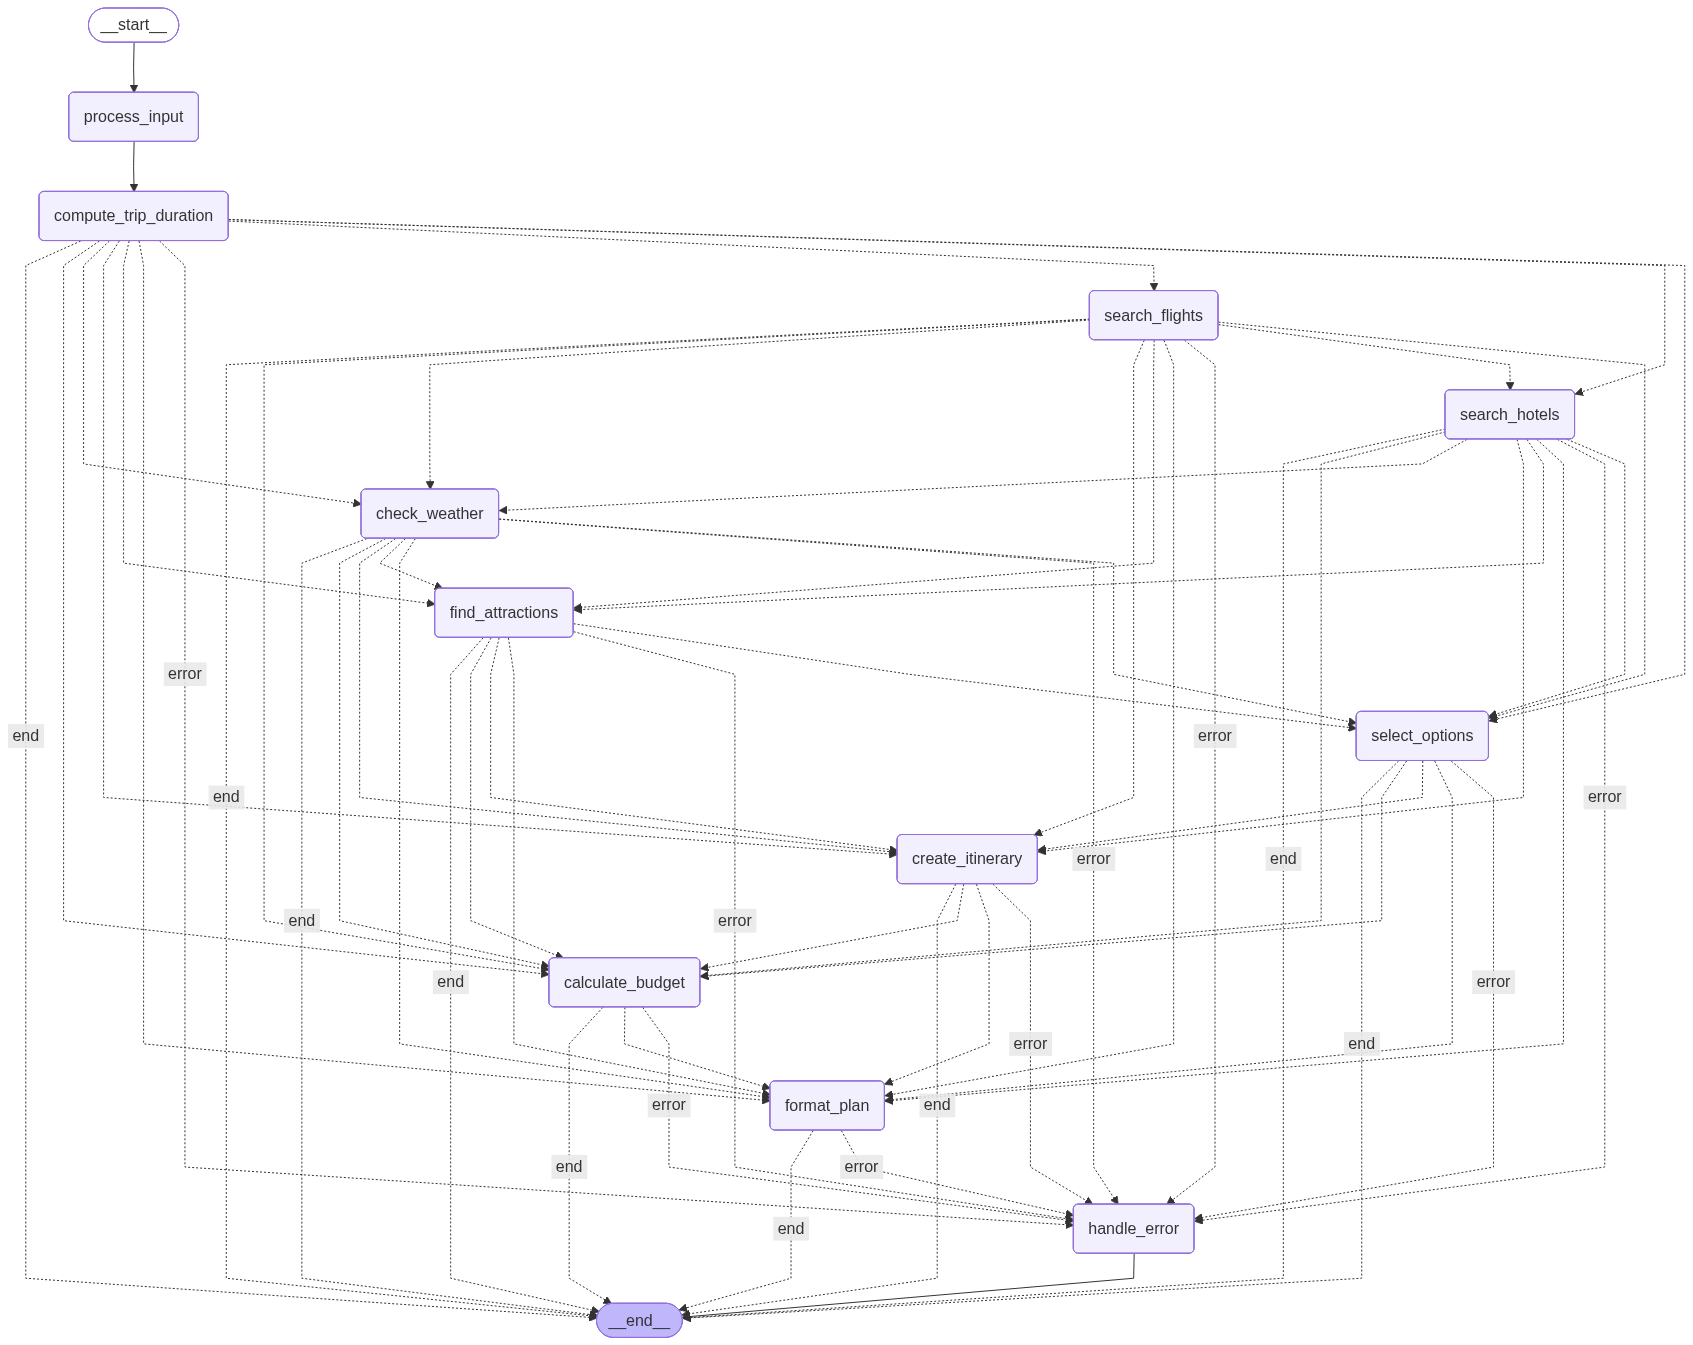

In [26]:

from IPython.display import Image, display

try:
    display(Image(travel_planner.get_graph().draw_mermaid_png(max_retries=1, retry_delay=2.0)))
except Exception as e:
    print(e)

In [105]:
# This code compiles the travel planner graph into an executable agent, defines a helper function to
#  run it end-to-end, and visualizes the workflow. It’s the final setup that allows you to input a travel
#   request and get a complete, formatted travel plan, handling errors and routing automatically.

In [27]:
# Compile and Test the Travel Planner

# Compile the graph
travel_planner = travel_planner_graph.compile()

print("⚙️ Compiling travel planner graph...")
print("✅ Travel Planner Agent compiled successfully!")
print("🚀 Ready to plan amazing trips!")

# Test function
def plan_trip(user_request: str):
    """
    Plan a complete trip based on user request.

    Args:
        user_request: User's travel planning request

    Returns:
        Complete travel plan
    """
    print(f"🌍 Planning trip based on: '{user_request}'")
    print("=" * 60)

    # Create initial state
    initial_state = create_initial_state(user_request)

    # Execute the travel planning workflow
    try:
        final_state = travel_planner.invoke(initial_state)

        print("\n" + "=" * 60)
        print("🎉 TRAVEL PLANNING COMPLETE!")
        print("=" * 60)

        # Print the beautiful final plan
        if final_state.get('final_plan'):
            print(final_state['final_plan'])
        else:
            print("❌ No final plan generated")

        return final_state

    except Exception as e:
        print(f"❌ Error during planning: {e}")
        return None

# Graph visualization
print("\n📊 Graph Visualization:")
print("=" * 40)
try:
    # Simple ASCII representation
    print("""
┌─────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│   START     │───▶│ process_input│───▶│search_flights│───▶│search_hotels │
└─────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
                                                                    │
                                                                    ▼
┌─────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│handle_error │◀───┤    END       │◀───┤format_plan   │◀───┤check_weather │
└─────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
       ▲                   ▲                   ▲                   │
       │                   │                   │                   ▼
       │           ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
       └───────────┤calc_budget   │◀───┤create_itinerary◀─┤find_attractions
                   └──────────────┘    └──────────────┘    └──────────────┘
                           ▲                   ▲                   │
                           │                   │                   ▼
                   ┌──────────────┐           │            ┌──────────────┐
                   │select_options│───────────┘            │  (routing)   │
                   └──────────────┘                        └──────────────┘
    """)

    print("🔗 Workflow Features:")
    print("   • Conditional routing based on planning stage")
    print("   • Error handling at every step")
    print("   • State accumulation throughout process")
    print("   • Comprehensive output formatting")

except Exception as e:
    print(f"Visualization error: {e}")

print("\n🎯 Travel Planner Agent is ready to use!")
print("💡 Call plan_trip(your_request) to start planning")

⚙️ Compiling travel planner graph...
✅ Travel Planner Agent compiled successfully!
🚀 Ready to plan amazing trips!

📊 Graph Visualization:

┌─────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│   START     │───▶│ process_input│───▶│search_flights│───▶│search_hotels │
└─────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
                                                                    │
                                                                    ▼
┌─────────────┐    ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
│handle_error │◀───┤    END       │◀───┤format_plan   │◀───┤check_weather │
└─────────────┘    └──────────────┘    └──────────────┘    └──────────────┘
       ▲                   ▲                   ▲                   │
       │                   │                   │                   ▼
       │           ┌──────────────┐    ┌──────────────┐    ┌──────────────┐
       └───────────┤calc_budget   │◀───┤create_itin

In [28]:

print("🎬 DEMO: Planning a sample trip")
print("=" * 50)

# Sample user request
#sample_request = """
#I want to plan a romantic trip to Paris for 3 people from June 15, 2024 to June 22, 2024.
#Our budget is $3000. We love museums, local cuisine, and historic sites.
#We're departing from New York.
#"""
# Sample user request
sample_request ="""
I want to travel from London to Paris from June 15, 2024 to June 25, 2024.
I have a budget of $4000 for 2 people. 
I'm interested in temples, food, and gardens.
"""

print(f"📝 Sample Request:")
print(sample_request)

🎬 DEMO: Planning a sample trip
📝 Sample Request:

I want to travel from London to Paris from June 15, 2024 to June 25, 2024.
I have a budget of $4000 for 2 people. 
I'm interested in temples, food, and gardens.



In [29]:

result = plan_trip(sample_request)

🌍 Planning trip based on: '
I want to travel from London to Paris from June 15, 2024 to June 25, 2024.
I have a budget of $4000 for 2 people. 
I'm interested in temples, food, and gardens.
'
🔍 Processing user input...
🤖 Using LLM for intelligent extraction...
✅ Parsed request:
   🏙️ Origin: London
   🎯 Destination: Paris
   📅 Dates: 2024-06-15 to 2024-06-25
   👥 Travelers: 2
   💰 Budget: 4000.0
   🎭 Type: round-trip
   🎨 Preferences: ['temples', 'food', 'gardens']
🧮 Trip duration computed: 10 days, 10 nights
🔄 Routing from stage: flight_search
➡️ Next stage: search_hotels
🏨 Searching for hotels...
HOTEL NODE STATE KEYS: dict_keys(['user_request', 'travel_request', 'trip_days', 'trip_nights', 'flight_options', 'hotel_options', 'weather_info', 'attractions', 'selected_flight', 'selected_hotel', 'itinerary', 'total_cost', 'cost_breakdown', 'planning_stage', 'errors', 'completed_steps', 'final_plan'])
trip_nights value: 10
✅ Found 3 hotels within budget ($240/night):
   • Hotel du Louvre: 